# Feature Preprocessing

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

## Load The Raw Features

### `Train`

In [34]:
text_train = pd.read_csv('../features/raw_train_text_features.csv', index_col=0)
text_train

,dialog_id,speaker,da_tag,start_time,end_time,function,pronoun,ppron,i,we,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
1,sw2005,B,x,0.00000,10.94882,0.000000,0.000000,0.000000,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,sw2005,A,x,10.93013,21.35084,0.000000,0.000000,0.000000,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,sw2005,B,sv,10.94882,22.28000,0.642857,0.285714,0.190476,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0
5,sw2005,A,b,21.35084,22.08088,0.000000,0.000000,0.000000,0.000000,0.000,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0
7,sw2005,B,sd,22.28000,26.72000,0.666667,0.250000,0.250000,0.083333,0.000,...,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.083333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82221,sw4940,A,x,291.40000,294.59659,0.000000,0.000000,0.000000,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
82224,sw4940,B,sd,294.62349,297.66445,0.375000,0.250000,0.125000,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
82225,sw4940,A,x,295.00000,298.58336,0.000000,0.000000,0.000000,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
82226,sw4940,B,x,297.66445,299.88000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [29]:
speech_train = pd.read_csv('../features/raw_train_speech_features.csv', index_col=0)
speech_train

,dialog_id,speaker,da_tag,start_time,end_time,Min Pitch,Max Pitch,Mean Pitch,Sd Pitch,Min Intensity,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
0,sw2015,A,x,0.00000,2.36986,174.046508,174.066746,174.054179,0.007531,27.397755,78.526451,61.632826,8.104074,0.421966,0.000111,0.030335,13.731803
1,sw2015,A,qy,2.36986,7.66596,93.313373,256.387580,127.352474,35.210170,27.913918,62.486222,55.339087,9.229627,3.965182,0.016218,0.090979,10.927442
2,sw2015,A,"fo_o_fw_""""_by_bc",7.66596,11.57304,75.651108,148.327094,117.173620,16.502379,27.797807,65.919881,55.229903,12.941730,1.535674,0.015932,0.075782,12.392446
3,sw2015,A,"fo_o_fw_""""_by_bc",11.57304,16.74866,82.132057,151.844450,117.921692,11.688333,27.548523,63.903176,56.596460,14.108906,1.738922,0.014186,0.064153,12.949125
4,sw2015,A,"fo_o_fw_""""_by_bc",16.74866,20.80178,74.854123,407.131028,129.184825,47.330238,27.540912,65.497511,57.328283,13.808277,2.467235,0.015583,0.069807,11.831661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12877,sw4877,B,sd,276.04000,277.44000,153.444223,237.586931,193.009039,25.048678,21.178252,63.187813,54.954631,10.400121,2.857143,0.020171,0.074572,13.986340
12878,sw4877,B,sd,277.88000,278.96000,157.771439,262.360631,186.165848,25.431514,35.171473,67.721781,58.099516,9.621780,6.481481,0.022235,0.108913,14.221476
12879,sw4877,B,sd,278.96000,285.08000,71.759943,201.412772,162.545562,20.225373,30.534469,63.319853,53.391527,8.468471,3.921569,0.014194,0.076282,15.089606
12880,sw4877,B,aa,285.08000,286.84000,165.954453,236.394955,193.289191,15.574607,16.495724,62.930966,53.899828,16.047028,0.568182,0.014557,0.050804,16.038953


### `Test`

In [25]:
text_test = pd.read_csv('../features/raw_test_text_features.csv', index_col=0)
text_test

,dialog_id,speaker,da_tag,start_time,end_time,function,pronoun,ppron,i,we,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,sw2015,A,x,0.00000,2.36986,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,sw2015,B,x,0.00000,24.29833,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,sw2015,A,qy,2.36986,7.66596,0.619048,0.190476,0.047619,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,sw2015,A,"fo_o_fw_""""_by_bc",7.66596,11.57304,0.500000,0.166667,0.166667,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,sw2015,A,"fo_o_fw_""""_by_bc",11.57304,16.74866,0.444444,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15401,sw4877,A,bf,286.40000,287.42550,0.600000,0.200000,0.200000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
15402,sw4877,B,sd,286.84000,299.04000,0.500000,0.071429,0.071429,0.071429,0.000000,...,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0
15403,sw4877,A,x,287.42550,289.12000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
15405,sw4877,A,x,289.44587,290.24000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [26]:
speech_test = pd.read_csv('../features/raw_test_speech_features.csv', index_col=0)
speech_test

FileNotFoundError: [Errno 2] No such file or directory: '../features/raw_test_speech_features.csv'

## Distribute Classes

In [ ]:
# View the data distribution and even it out.

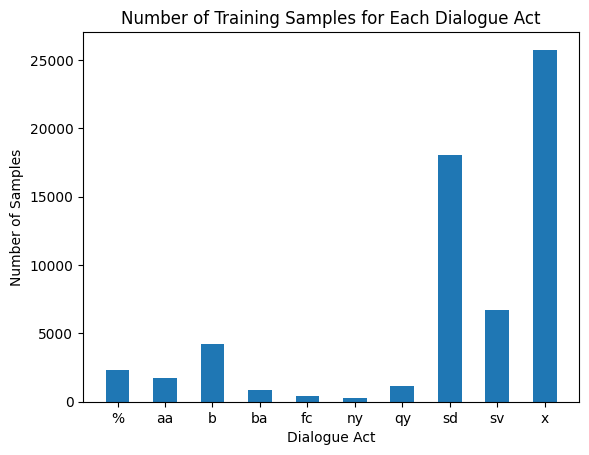

In [39]:
da_tags = []
num_samples = []

for row, item in text_train.groupby('da_tag'):
    da_tags.append(row)
    num_samples.append(len(item))

plt.bar(da_tags, num_samples, width=0.5)

plt.xlabel('Dialogue Act')
plt.ylabel('Number of Samples')
plt.title('Number of Training Samples for Each Dialogue Act')

plt.show()

## Normalize